<a href="https://colab.research.google.com/github/Daniel1989/fastai_course/blob/main/fastai_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
import os
from google.colab import userdata
# Replace with your Pexels API key
API_KEY = userdata.get('PEXELS_API_KEY')
BASE_URL = "https://api.pexels.com/v1/search"

def search_and_download_images(query, num_images=5):
    save_dir = "./downloaded_images/"+query
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Set up headers with API key
    headers = {
        "Authorization": API_KEY
    }

    # Set up parameters for the API request
    params = {
        "query": query,
        "per_page": num_images
    }

    try:
        # Make the API request
        response = requests.get(BASE_URL, headers=headers, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Parse the JSON response
        data = response.json()
        photos = data.get("photos", [])

        if not photos:
            print("No images found for the query.")
            return

        # Download each image
        for i, photo in enumerate(photos, 1):
            image_url = photo["src"]["original"]
            image_extension = image_url.split(".")[-1]
            filename = f"{save_dir}/{query.replace(' ', '_')}_{i}.{image_extension}"

            # Download the image
            image_response = requests.get(image_url)
            image_response.raise_for_status()

            # Save the image locally
            with open(filename, "wb") as f:
                f.write(image_response.content)
            print(f"Downloaded: {filename}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")


Downloaded: ./downloaded_images/grizzly/grizzly_1.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_2.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_3.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_4.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_5.jpg
Downloaded: ./downloaded_images/grizzly/grizzly_6.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_7.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_8.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_9.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_10.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_11.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_12.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_13.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_14.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_15.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_16.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_17.jpeg
Downloaded: ./downloaded_images/grizzly/grizzly_18.jpeg
Do

In [4]:
number_of_images = 100
search_and_download_images("grizzlybears", number_of_images)
search_and_download_images("blackbears", number_of_images)
search_and_download_images("teddybears", number_of_images)

Downloaded: ./downloaded_images/grizzlybears/grizzlybears_1.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_2.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_3.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_4.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_5.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_6.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_7.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_8.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_9.jpeg
Downloaded: ./downloaded_images/grizzlybears/grizzlybears_10.jpeg
Downloaded: ./downloaded_images/blackbears/blackbears_1.jpeg
Downloaded: ./downloaded_images/blackbears/blackbears_2.jpeg
Downloaded: ./downloaded_images/blackbears/blackbears_3.jpeg
Downloaded: ./downloaded_images/blackbears/blackbears_4.jpeg
Downloaded: ./downloaded_images/blackbears/blackbears_5.jpeg
Downloaded: ./downloaded_images/blackbears/b

In [12]:
# 这个包含了fastai框架
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
# 初始化
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [14]:
from fastbook import *
from fastai.vision.widgets import *
# 5个组成部分，block，一个
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # 前者自变量是我们用来进行预测的因素，而后者因变量是我们的目标。
    get_items=get_image_files, # get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # seed通过提供同样的启动点，来确保创建的数值一致
    get_y=parent_label, # 一个function 获取y的label
    item_tfms=Resize(128)) # 将所有图片弄成一个size，这样产生的tensorsize才一致

In [16]:
path = Path('downloaded_images')
dls = bears.dataloaders(path)


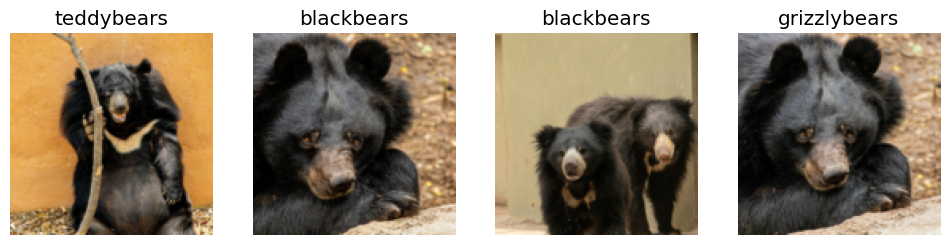

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)


# 新段落